In this notebook we will  use  transfer learning and take pretrained model from google's Tensorflow Hub and re-train that on flowers dataset

Using pretrained model saves a lot of time and computation budget for new classification problem at hand.

- Switched to MobileNetV2 feature extractor
- Froze base layers for stable convergence
- Improved classification head
- Updated training pipeline

In [2]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

c:\Users\ogech\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



Make predictions using ready made model (without any training)

In [6]:
IMAGE_SHAPE = (224, 224, 3)

classifier = tf.keras.Sequential([
    tf.keras.layers.Input(shape=IMAGE_SHAPE),
    tf.keras.layers.Lambda(lambda x: tf.keras.applications.mobilenet_v2.preprocess_input(x)),
    tf.keras.applications.MobileNetV2(
        input_shape=IMAGE_SHAPE,
        include_top=True,
        weights='imagenet'
    )
])

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 41s 3us/step



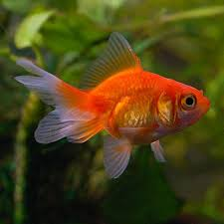

In [13]:
from PIL import Image

# Define only width and height
IMAGE_SHAPE = (224, 224)  # Just width and height

gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [14]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [15]:
gold_fish[np.newaxis, ...]

array([[[[0.2627451 , 0.35686275, 0.01176471],
         [0.28627451, 0.38039216, 0.03529412],
         [0.3254902 , 0.42745098, 0.08627451],
         ...,
         [0.31764706, 0.38823529, 0.        ],
         [0.31764706, 0.38823529, 0.        ],
         [0.30980392, 0.36078431, 0.01568627]],

        [[0.2627451 , 0.35686275, 0.02745098],
         [0.29019608, 0.38431373, 0.05490196],
         [0.32941176, 0.42352941, 0.09411765],
         ...,
         [0.32156863, 0.39215686, 0.        ],
         [0.3254902 , 0.38823529, 0.00392157],
         [0.30196078, 0.35294118, 0.00784314]],

        [[0.26666667, 0.34901961, 0.04705882],
         [0.29019608, 0.38039216, 0.0745098 ],
         [0.32941176, 0.41960784, 0.11372549],
         ...,
         [0.3254902 , 0.39215686, 0.        ],
         [0.3254902 , 0.38823529, 0.        ],
         [0.29411765, 0.34509804, 0.        ]],

        ...,

        [[0.03529412, 0.13333333, 0.01568627],
         [0.03529412, 0.13333333, 0.01568627]

In [16]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 1000)

In [17]:
predicted_label_index = np.argmax(result)
predicted_label_index

np.int64(818)

In [19]:
# Download the ImageNet labels file
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)

# Read the labels
with open(labels_path, "r") as f:
    image_labels = f.read().splitlines()

print(f"Total labels: {len(image_labels)}")
print("First 5 labels:", image_labels[:5])

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Total labels: 1001
First 5 labels: ['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']


In [20]:
image_labels[predicted_label_index]

'sports car'

Load flowers dataset

In [21]:
data_dir = ('./datasets/flower_photos')
data_dir

'./datasets/flower_photos'

In [22]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [23]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [24]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [25]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

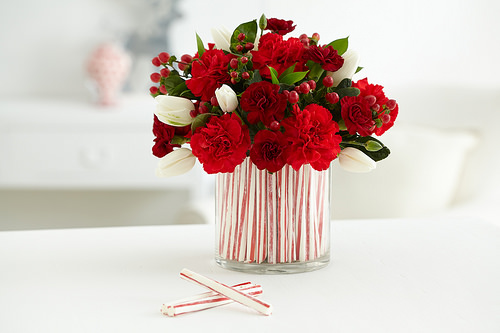

In [30]:
Image.open(str(roses[120]))

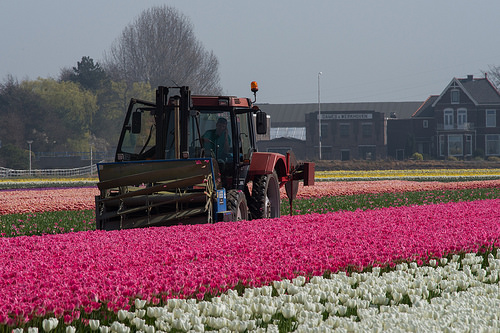

In [29]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[89]))

Read flowers images from disk into numpy array using opencv

In [31]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [32]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [33]:

flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [34]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [35]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(240, 179, 3)

In [36]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [37]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [38]:
X = np.array(X)
y = np.array(y)

Train test split

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing: scale images

In [41]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Make prediction using pre-trained model on new flowers dataset

In [42]:
X[0].shape

(224, 224, 3)

In [43]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [44]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

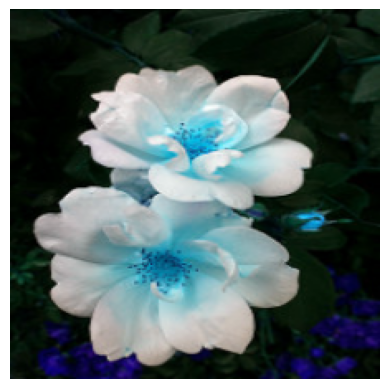

In [45]:
plt.axis('off')
plt.imshow(X[0])

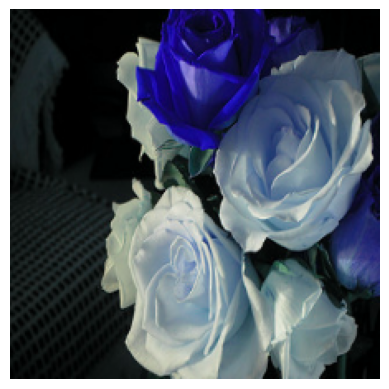

In [46]:
plt.axis('off')
plt.imshow(X[1])

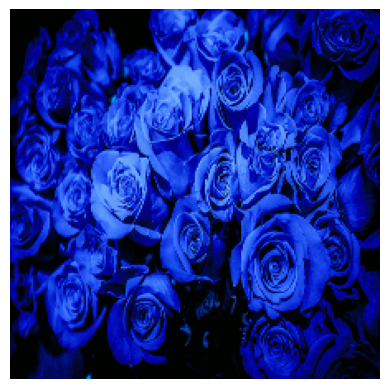

In [47]:
plt.axis('off')
plt.imshow(X[2])

In [48]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([584, 459, 885])

In [50]:
image_labels[584]

'guillotine'

In [51]:
image_labels[459]

'brass'

In [52]:
image_labels[885]

'vault'

Now take pre-trained model and retrain it using flowers images

In [53]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [55]:
num_of_flowers = 5

# Create MobileNetV2 without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'  # Global average pooling
)

# Freeze the base model
base_model.trainable = False

# Create the complete model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 23s 2us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [56]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 69s 683ms/step - acc: 0.6864 - loss: 0.8428
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 622ms/step - acc: 0.8517 - loss: 0.4471
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 631ms/step - acc: 0.8881 - loss: 0.3482
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 54s 629ms/step - acc: 0.9084 - loss: 0.2975
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 60s 695ms/step - acc: 0.9161 - loss: 0.2611


In [57]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - acc: 0.8584 - loss: 0.4280


[0.4280441403388977, 0.85838782787323]